In [1]:
# default_exp preprocessing_pipeline

# Finding an optimal preprocessing pipeline for control samples

In this notebook we try to find the steps in a preprocessing pipeline that lead to a relatively homogeneous dimensionality reduction of the control samples. The idea is that we expect no process of interest in the control samples, so a good preprocessing strategy should reflect that and not introduce any unwanted artifacts. If this same strategy is applied on case (infected) samples, we can assume that effects showing up in down stream analyses are due to biological or technical artifacts and not due to the preprocessing.

See [slides](https://slides.com/mlippie/normalization-strategy)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# %load common.py
# export

import pandas
import os
import numpy
import seaborn
import logging
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib
from importlib import reload
from ehv import core
from joblib import load, dump
from pathlib import Path
import uuid
import re
import scipy

from ehv import load as e_load, core

plt.rcParams['figure.facecolor'] = 'white'

numpy.random.seed(42)

In [4]:
# export
from ehv import correlation
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, Normalizer
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import FastICA, PCA, KernelPCA
from umap import UMAP
from multiprocessing import Pool, cpu_count

In [5]:
df = e_load.load_raw_ideas_dir(
    Path("/data/weizmann/EhV/high_time_res"), 
    Path("/data/weizmann/EhV/weizmann-ehv-metadata/representations/ideas_features/"), 
    "ALL", 
    Path("/data/weizmann/EhV/weizmann-ehv-metadata/cell_populations/manual_gating/"),
    None, "*.cif")
df = e_load.clean_column_names(df)
df = e_load.remove_unwanted_features(df)
df = e_load.tag_columns(df)

df = df[df["meta_label_coi"]]

reg = r"^meta_label_(.+)$"
label_vec = numpy.full((df.shape[0]), fill_value="unknown", dtype=object)
for col in df.filter(regex="(?i)meta_label_.*psba.*"):
    label_vec[df[col].values] = re.match(reg, col).groups(1)
    
df["meta_label"] = label_vec

df = df.reset_index(drop=True)

In [6]:
# drop mcp pos cells
df = df[~((df["feat_cont_area_m04"] > 0) & (df["meta_group"] == 'Ctrl'))]

## Setting up preprocessing pipelines

Steps:
1. Correlation
1. Scaling
1. Dimensionality reduction

In [7]:
# export
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.base import TransformerMixin, BaseEstimator, clone

In [8]:
# export
class GroupedTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, base_transformer, group_key, n_jobs=-1):
        self.base_transformer = base_transformer
        self.group_key = group_key
        self.n_jobs = n_jobs if n_jobs >= 1 else cpu_count()
        
    def fit(self, df):
        self.transformers = {}
        with Pool(processes=self.n_jobs) as pool:
            for idx, gdf in df.groupby(self.group_key):
                self.transformers[idx] = pool.apply_async(clone(self.base_transformer).fit, args=(gdf.drop(columns=self.group_key),))
            for k,v in self.transformers.items():
                self.transformers[k] = v.get()
        return self
            
    def transform(self, df):
        columns = df.drop(columns=self.group_key).columns
        dfs = []
        with Pool(processes=self.n_jobs) as pool:
            promises = []
            for idx, gdf in df.groupby(self.group_key):
                promises.append(pool.apply_async(self.transformers[idx].transform, args=(gdf[columns],)))
            for (promise, (idx, gdf)) in zip(promises, df.groupby(self.group_key)):
                gdf[columns] = promise.get()
                dfs.append(gdf)
        return pandas.concat(dfs)
    
class ColumnTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, transformer, col_selector, append=False, drop_remainder=False):
        self.transformer = transformer
        self.col_selector = col_selector
        self.append = append
        self.drop_remainder = drop_remainder
        
    def fit(self, df, y=None):
        self.transformer.fit(df[self.col_selector(df)])
        return self
    
    def transform(self, df, y=None):
        
        data = self.transformer.transform(df[self.col_selector(df)])
        if hasattr(data, "iloc"):
            tmp_df = data
        else:
            if len(self.col_selector(df)) == data.shape[1]:
                columns = self.col_selector(df)
            else:
                columns = ["feat_%s_%s" % (self.transformer.__class__.__name__.lower(), i) for i in range(data.shape[1])]
                
            tmp_df = pandas.DataFrame(
                data = data,
                columns = columns,
                index = df.index
            )
                
        if self.append:
            return pandas.concat([df, tmp_df], axis=1)
        elif self.drop_remainder:
            return pandas.concat([df.drop(columns=self.col_selector(df)), tmp_df], axis=1)
        else:
            df = df.copy()
            df[self.col_selector(df)] = tmp_df
            return df
        
    
class PandasVarianceThreshold(BaseEstimator, TransformerMixin):
    def __init__(self, thresh=0.0):
        self.thresh = thresh
        self.var = VarianceThreshold()
        
    def fit(self, X):
        self.var.fit(X)
        return self
    
    def transform(self, X):
        return X[X.columns[self.var.get_support()]]

In [9]:
feat_selector = make_column_selector(pattern="feat")
meta_selector = make_column_selector(pattern="^(feat|meta_timepoint).*")

## Robust scale

In [12]:
pipe = Pipeline([
    ("correlation", ColumnTransformer(correlation.Correlation(0.92), meta_selector)),
    ("grouped_robust_scaler", ColumnTransformer(GroupedTransformer(RobustScaler(quantile_range=(0.05, 0.95)), "meta_timepoint"), meta_selector)),
    ("pca", ColumnTransformer(PCA(n_components=0.95, random_state=42), feat_selector, append=True)),
    ("umap", ColumnTransformer(UMAP(n_components=2, random_state=42), make_column_selector(pattern="feat_pca"), append=True))
])

In [14]:
%%time
res = pipe.fit_transform(df[df["meta_group"] == "Ctrl"])

CPU times: user 49min 19s, sys: 15min 22s, total: 1h 4min 42s
Wall time: 7min 46s


<AxesSubplot:xlabel='feat_umap_0', ylabel='feat_umap_1'>

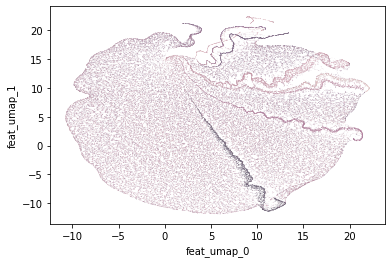

In [15]:
seaborn.scatterplot(data=res, x="feat_umap_0", y="feat_umap_1", hue="meta_timepoint", s=0.1, alpha=0.5, edgecolors='none', legend=False)

<AxesSubplot:xlabel='feat_umap_0', ylabel='feat_umap_1'>

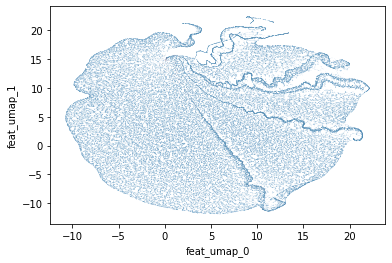

In [16]:
seaborn.scatterplot(data=res, x="feat_umap_0", y="feat_umap_1", hue="meta_label", hue_order=["mcp_neg_psba_pos", "mcp_pos_psba_pos", "mcp_pos_psba_neg", "mcp_neg_psba_neg", "unknown"], legend=False, s=0.1, alpha=0.5, edgecolors='none')

## Minmax + standard scale

In [88]:
%%time
pipe = Pipeline([
    ("correlation", ColumnTransformer(correlation.Correlation(0.92), meta_selector)),
    ("grouped_minmax_scaler", ColumnTransformer(GroupedTransformer(MinMaxScaler(), "meta_timepoint"), meta_selector)),
    ("grouped_standard_scaler", ColumnTransformer(GroupedTransformer(StandardScaler(), "meta_timepoint"), meta_selector)),
    ("pca", ColumnTransformer(PCA(n_components=0.95, random_state=42), feat_selector, append=True)),
    ("umap", ColumnTransformer(UMAP(n_components=2, random_state=42), make_column_selector(pattern="feat_pca"), append=True))
])
res2 = pipe.fit_transform(df[df["meta_group"] == "Ctrl"])

/opt/conda/envs/env/lib/python3.8/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


KeyboardInterrupt: 

In [89]:
seaborn.scatterplot(data=res2, x="feat_umap_0", y="feat_umap_1", hue="meta_timepoint", s=0.1, alpha=0.5, edgecolors='none', legend=False)

NameError: name 'res2' is not defined

## Normalize + Power transform

In [10]:
# export
def make_pipeline_1():
    feat_selector = make_column_selector(pattern="feat")
    meta_selector = make_column_selector(pattern="^(feat|meta_timepoint).*")
    return Pipeline([
        ("zero_var", ColumnTransformer(PandasVarianceThreshold(), feat_selector, drop_remainder=True)),
        ("correlation", ColumnTransformer(correlation.Correlation(0.92), feat_selector, drop_remainder=True)),
        ("normalize", ColumnTransformer(Normalizer(), feat_selector)),
        ("power_transform", ColumnTransformer(PowerTransformer(), feat_selector)),
        ("pca", ColumnTransformer(PCA(n_components=0.95, random_state=42), feat_selector, append=True)),
        ("umap", ColumnTransformer(UMAP(n_components=2, random_state=42, metric="cosine"), make_column_selector(pattern="feat_pca"), append=True))
    ])

In [11]:
df.shape

(852439, 114)

In [12]:
df["meta_label"]

0         mcp_neg_psba_pos
1         mcp_neg_psba_pos
2         mcp_neg_psba_pos
3         mcp_neg_psba_pos
4         mcp_neg_psba_pos
                ...       
857888    mcp_neg_psba_pos
857889    mcp_neg_psba_pos
857890    mcp_neg_psba_pos
857891    mcp_pos_psba_pos
857892    mcp_pos_psba_pos
Name: meta_label, Length: 852439, dtype: object

In [13]:
%%time
pipe = make_pipeline_1()

# Feedback needed from Flora about ch2 and ch3
res3 = pipe.fit_transform(df[df["meta_group"] == "Ctrl"].drop(columns=df.filter(regex="(m|ch)0?(2|3)")))

CPU times: user 10min 37s, sys: 2min 2s, total: 12min 39s
Wall time: 4min 5s


In [31]:
u = uuid.uuid4()

In [21]:
res3["test_col"] = 0.5

In [14]:
res3.reset_index()

,index,meta_system_object_number,meta_system_time,meta_system_flow_speed,meta_timepoint,meta_replicate,meta_group,meta_label_coi,meta_label_mcp_neg_psba_pos,meta_label_mcp_pos_psba_pos,...,feat_pca_9,feat_pca_10,feat_pca_11,feat_pca_12,feat_pca_13,feat_pca_14,feat_pca_15,feat_pca_16,feat_umap_0,feat_umap_1
0,0,0,0.000000,43.292953,5,R2,Ctrl,True,True,False,...,-0.290055,0.999587,-0.704473,0.378123,-0.490176,-0.734785,-0.383089,-0.264955,6.956544,-1.677827
1,1,1,0.000384,43.292953,5,R2,Ctrl,True,True,False,...,-0.557055,-0.149027,-0.223939,0.276844,-1.399932,0.135271,-0.773360,-0.258220,-1.596302,3.906558
2,2,3,0.002077,43.268673,5,R2,Ctrl,True,True,False,...,0.412459,0.015453,0.798913,0.016851,0.724816,1.370778,-0.316483,0.378922,9.649984,0.073789
3,3,6,0.003819,43.292953,5,R2,Ctrl,True,True,False,...,-0.044808,0.272312,-0.162225,0.529357,0.122032,0.019483,0.194921,0.143119,5.000072,-0.897931
4,4,7,0.005560,43.268673,5,R2,Ctrl,True,True,False,...,-0.334668,0.759679,-0.163036,1.490026,-0.081917,-0.996512,0.693692,0.015317,9.118218,8.588170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222893,228347,19993,26.043028,43.365959,11,R1,Ctrl,True,True,False,...,-0.346965,-0.366993,0.199434,-0.452916,-0.557676,-0.158807,0.597854,0.299787,-0.062838,4.363157
222894,228348,19994,26.043604,43.365959,11,R1,Ctrl,True,True,False,...,-0.339895,0.488607,-0.623009,-0.472427,-1.383473,0.042189,0.407191,0.751288,12.623241,1.201742
222895,228349,19996,26.045630,43.365959,11,R1,Ctrl,True,True,False,...,0.101620,-0.682717,0.606431,1.028872,0.340755,-0.797985,0.146623,0.809871,7.772885,1.380648
222896,228350,19997,26.047079,43.365959,11,R1,Ctrl,True,True,False,...,-0.117462,-0.193464,-0.221833,0.251436,-0.505271,-0.589233,0.330859,-0.057821,12.619190,2.482156


In [37]:
res3 = res3.reset_index()
for col in res3:
    if(res3[col].dtype == numpy.int64):
        res3[col] = res3[col].astype(numpy.int32)

res3.to_feather("/data/weizmann/test.feather", compression="uncompressed")

In [228]:
dump(res3.filter(regex="feat_umap"), "/data/weizmann/EhV/weizmann-ehv-metadata/representations/umap/Ctrl/%s.dat" % u)

['/data/weizmann/EhV/weizmann-ehv-metadata/representations/umap/Ctrl/3654c1c0-dac4-47af-a32a-bd84ccef036e.dat']

<AxesSubplot:xlabel='feat_umap_0', ylabel='feat_umap_1'>

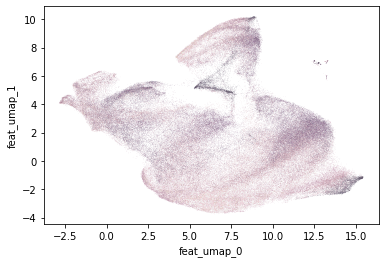

In [37]:
seaborn.scatterplot(data=res3, x="feat_umap_0", y="feat_umap_1", hue="meta_timepoint", s=0.1, alpha=0.5, edgecolors='none', legend=False)
# plt.savefig("/data/weizmann/EhV/weizmann-ehv-metadata/representations/umap/assets/thumbs/%s.jpg" % u)

In [43]:
res3.to_csv(path_or_buf="/data/weizmann/ctrl.csv", index=False)

In [44]:
res3.iloc[:1000].to_csv(path_or_buf="/data/weizmann/ctrl_small.csv", index=False)

In [213]:
res3.filter(regex="feat").corr()["feat_umap_1"].abs().sort_values(ascending=False)

feat_umap_1                                     1.000000
feat_pca_1                                      0.683473
feat_cont_bright_detail_intensity_r3_mc_ch11    0.582028
feat_cont_bright_detail_intensity_r3_mc_bf2     0.565190
feat_cont_median_pixel_m09_bf2                  0.559598
                                                  ...   
feat_cont_intensity_mc_ch04                     0.029200
feat_cont_contrast_m06_ssc                      0.026857
feat_pca_3                                      0.021152
feat_pca_15                                     0.012005
feat_cont_modulation_m11_ch11                   0.004361
Name: feat_umap_1, Length: 76, dtype: float64

<AxesSubplot:xlabel='feat_umap_0', ylabel='feat_umap_1'>

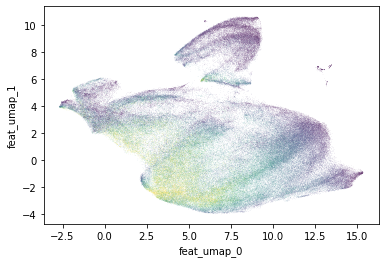

In [214]:
feat = "feat_cont_bright_detail_intensity_r3_mc_ch11"
norm = matplotlib.colors.Normalize(vmin=df[df["meta_group"] == 'Ctrl'][feat].quantile(0.05), vmax=df[df["meta_group"] == 'Ctrl'][feat].quantile(0.95))
seaborn.scatterplot(data=res3, x="feat_umap_0", y="feat_umap_1", c=df[df["meta_group"] == 'Ctrl'][feat], s=0.1, edgecolors="none", alpha=0.5, cmap="viridis", norm=norm)

In [215]:
res3.filter(regex="feat").corr()["feat_umap_0"].abs().sort_values(ascending=False)[:20]

feat_umap_0                                1.000000
feat_cont_gradient_rms_m09_bf2             0.875833
feat_cont_gradient_rms_m07_ch7             0.874912
feat_cont_gradient_rms_m11_ch11            0.864840
feat_cont_gradient_rms_m06_ssc             0.864359
feat_pca_0                                 0.851223
feat_cont_width_m07                        0.847530
feat_cont_modulation_m07_ch7               0.835762
feat_cont_gradient_rms_m01_bf              0.832634
feat_cont_width_m01                        0.813456
feat_cont_width_m11                        0.772593
feat_cont_aspect_ratio_m01                 0.766820
feat_cont_max_pixel_mc_bf                  0.766571
feat_cont_aspect_ratio_intensity_m01_bf    0.766225
feat_cont_width_m09                        0.758398
feat_cont_aspect_ratio_m11                 0.757501
feat_cont_aspect_ratio_m07                 0.756995
feat_cont_contrast_m07_ch7                 0.752857
feat_cont_aspect_ratio_m09                 0.750183
feat_cont_he

<AxesSubplot:xlabel='feat_umap_0', ylabel='feat_umap_1'>

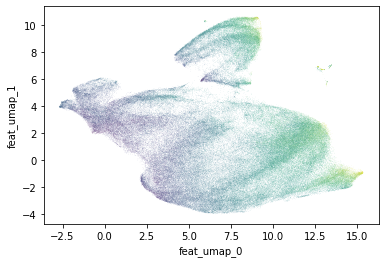

In [216]:
feat = "feat_cont_gradient_rms_m09_bf2"
norm = matplotlib.colors.Normalize(vmin=res3[feat].quantile(0), vmax=res3[feat].quantile(1))
seaborn.scatterplot(data=res3, x="feat_umap_0", y="feat_umap_1", c=res3[feat], s=0.1, edgecolors="none", alpha=0.5, cmap="viridis", norm=norm)

<AxesSubplot:xlabel='feat_umap_0', ylabel='feat_umap_1'>

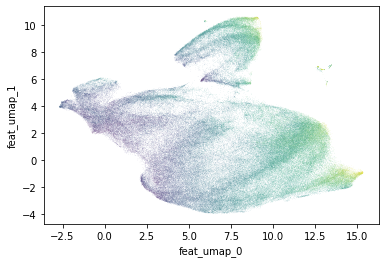

In [217]:
feat = "feat_cont_gradient_rms_m07_ch7"
norm = matplotlib.colors.Normalize(vmin=res3[feat].quantile(0), vmax=res3[feat].quantile(1))
seaborn.scatterplot(data=res3, x="feat_umap_0", y="feat_umap_1", c=res3[feat], s=0.1, edgecolors="none", alpha=0.5, cmap="viridis", norm=norm)

<AxesSubplot:xlabel='feat_umap_0', ylabel='feat_umap_1'>

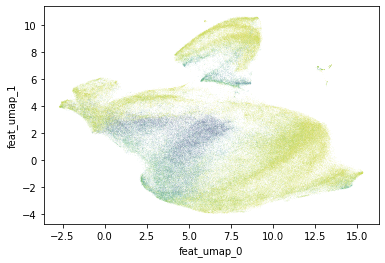

In [218]:
feat = "feat_cont_aspect_ratio_intensity_m07_ch7"
norm = matplotlib.colors.Normalize(vmin=df[df["meta_group"] == 'Ctrl'][feat].quantile(0), vmax=df[df["meta_group"] == 'Ctrl'][feat].quantile(1))
seaborn.scatterplot(data=res3, x="feat_umap_0", y="feat_umap_1", c=df[df["meta_group"] == 'Ctrl'][feat], s=0.1, edgecolors="none", alpha=0.5, cmap="viridis", norm=norm)